**Exercise and Lab: Pulse Shape Discrimination**

The goal of this exercise is to perform a pulse shape analysis on real data.

A scintillation detector is exposed to both neutron and gamma radiation, both emitted from a source places some half meter away from the detector. A detected particle (neutron or gamma) will result in an electrical pulse (a short signal) from the detector. However, the pulse shape of the detector signal depends looks different for both types of particles.

Together with the detector pulse, the flight time of the particle from the source to the detector is measured. (More on this in the introductory video for the lab.) Since gammas move at speed of light and neutrons don't, the flight times provide a second way of discriminating between neutrons and gammas, independent of the pulse shapes. Use this information to label the data.

We start by downloading a data file. For testing there is a small data set, once everything works, there is more data...

In [92]:
# load data
# The code snippet below is responsible for downloading the dataset
# - for example when running via Google Colab.
# It is enough to load one of the files below.

# Small data file. 
!gdown https://drive.google.com/uc?id=1Ejrt2O6rRj0N7F29pXxsa-gELsVaGhfA

# The small data file is enough to do this exercise but if you want you can also use much more data.
# Large data file. Uncomment this line only if you really want to use all data. 
# !gdown https://drive.google.com/uc?id=1AcMxtW3GFsKpkLqDLwlDxgYFtbtzcrZQ

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Ejrt2O6rRj0N7F29pXxsa-gELsVaGhfA 



The next step will be do load the data into a numpy array and check it, e.g. by looking at some pulses.

The data consists of a (high) number of lines, each line representing one pulse.

(55686, 514)
[   2.     100.905   -7.      -6.      -8.      -9.      -9.      -7.
   -9.      -8.      -8.      -5.      -8.      -8.     -11.      -8.
   -8.      -8.      -8.      -8.      -8.      -9.      -8.      -8.
   -8.      -6.      -7.      -8.      -7.      -7.     -10.      -7.
   -8.      -7.      -7.      -5.      -8.      -6.     -10.      -7.
   -8.      -8.      -8.      -7.      -7.      -5.     -10.      -8.
   -8.      -7.      -9.      -7.      -5.      -7.      -8.      -8.
   -7.      -6.      -5.      -4.     -10.     -10.      -7.      -9.
   -6.      -6.      -5.      -9.     -11.      -9.      -8.      -5.
   -6.      -8.     -10.      -9.      -6.      -5.      -5.     -10.
   -6.      -8.      -9.      -6.      -7.      -7.      -9.     -10.
   -9.      -6.      -8.      -6.     -10.      -8.      -8.      -6.
   -7.      -5.      -7.      -7.      -7.      -8.      -9.      -6.
   -7.      -9.      -8.      -8.      -7.      -9.      -8.      -6.
   -6. 

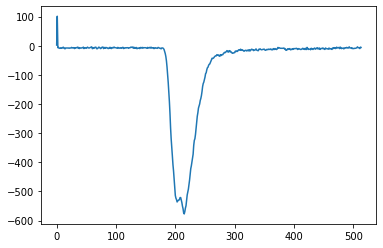

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tabulate import tabulate

data_raw = np.load('/content/data_small.npy')

# Check the size of the data file
print(data_raw.shape)
# Print the first pulse
plt.plot(data_raw[0])
# print(data[0])
print(data_raw[0])

The first number in each line is a detector identifier, which we can happily ignore here.

The second number is the flight time in nanoseconds, this provides information about the particle type, neutron or gamma.

The pulse is sampled at a rate of 1 GHz, so the remaining 512 numbers represent 512 ns of the pulse shape.

(55686, 512)


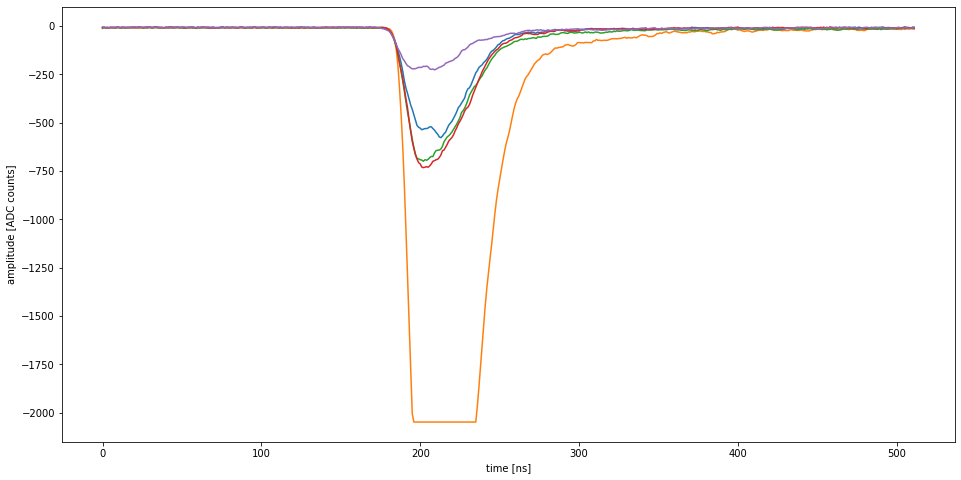

In [94]:
# Select only the pulse shape part of the data
pulses = data_raw[:,2:]
# Prepare a figure and plot some pulses
print(pulses.shape)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(pulses[0])
ax.plot(pulses[10])
ax.plot(pulses[100])
ax.plot(pulses[1000])
ax.plot(pulses[10000])
ax.set_xlabel("time [ns]")
ax.set_ylabel("amplitude [ADC counts]")
plt.show()

We will now extract the flight times.

In [95]:
times = data_raw[:,1]
print('Flight times between', times.min(), 'and', times.max(), 'nanoseconds.')

Flight times between -371.822 and 287.852 nanoseconds.


Negative flight times (also called times of flight, tof) are okay (for random coincidences), but we will restrict their range before plotting:

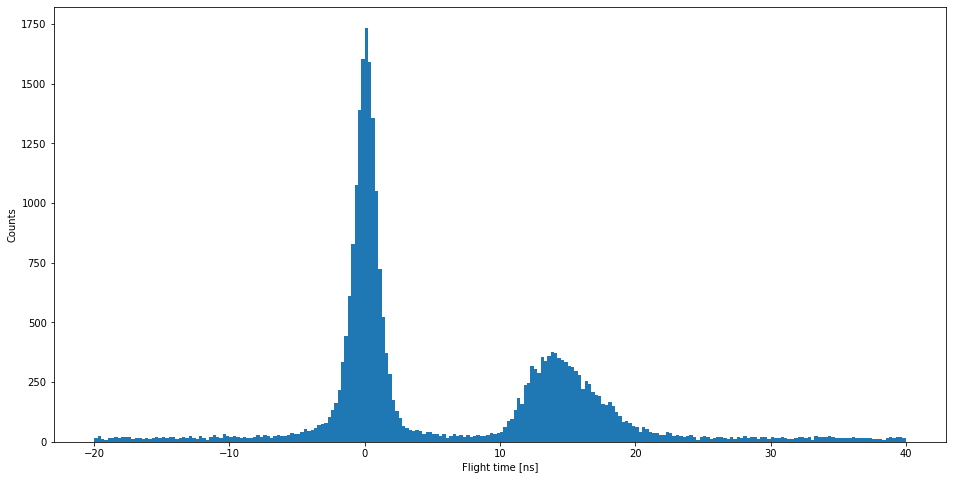

In [96]:
min_tof = -20
max_tof = 40
times = times[(times>=min_tof) & (times<=max_tof)]
# Now create a figure
fig, ax  = plt.subplots(figsize=(16,8))
ax.hist(times, bins=240)   # high resolution: 4 bins per nanosecond
ax.set_xlabel('Flight time [ns]')
ax.set_ylabel('Counts')
plt.show()

The flight time spectrum shows a gamma peak at around 0 ns and a neutron peak at around 10 to 20 ns.
You can now define flight time ranges within which you will accept gammas and neutrons. Please adjust the numbers below according to your data and your liking.
During the exercise class, we will discuss how the choice of the limits affects your results.

In [97]:
gamma_min_tof = -4
gamma_max_tof = 4
neutron_min_tof = 10
neutron_max_tof = 20

gammadata = data_raw[(data_raw[:,1] >= gamma_min_tof) & (data_raw[:,1] <= gamma_max_tof)]
gammapulses = gammadata[:,2:]
print('Gammas:  ', gammapulses.shape)

neutrondata = data_raw[(data_raw[:,1] >= neutron_min_tof) & (data_raw[:,1] <= neutron_max_tof)]
neutronpulses = neutrondata[:,2:]
print('Neutrons:', neutronpulses.shape)



Gammas:   (15539, 512)
Neutrons: (8690, 512)


You now have two arrays with pulse shapes, one with only gammas (according to the flight times) and one with only neutrons (again, according to the flight times). Each array contains a large number of pulse shapes, each pulse consists of 512 detector readings.

Let's start preparing the data for the training of a neural network.



In [98]:
# make a combined data set containing both pulse types
data = np.vstack((gammapulses, neutronpulses))
labels = np.zeros(len(data), dtype=int)
labels[:len(gammapulses)] = 1
# gammas are labelled as 1, and neutrons are labelled as 0

# normalize the data
minVal = np.min(data);
maxVal = np.max(data);
norm_data = (data - minVal) / ( maxVal - minVal )

samples_per_pulse = len(data[0])

# in case you use a CNN architecture, we need to add an empty axis. 
data = data[:,:, np.newaxis]  

# before we split up the dataset into training, validation and test data set, we need to shuffle the events
# otherwise we end up having only one type of event in our validation and test data sets. 
np.random.seed(1234)
shuffle_indices = np.arange(0, len(data), dtype=int)
np.random.shuffle(shuffle_indices)
data = data[shuffle_indices]
labels = labels[shuffle_indices]

data_train = data[:16960]
data_validation = data[16960:20594]
data_test = data[20594:]

labels_train = labels[:16960]
labels_validation = labels[16960:20594]
labels_test = labels[20594:]

labels_train_onehot = tf.keras.utils.to_categorical(labels_train, 2)
labels_validation_onehot = tf.keras.utils.to_categorical(labels_validation, 2)
labels_test_onehot = tf.keras.utils.to_categorical(labels_test, 2)

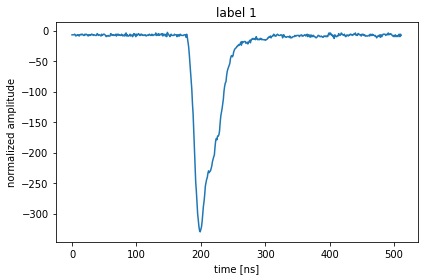

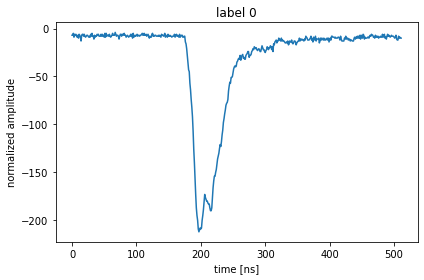

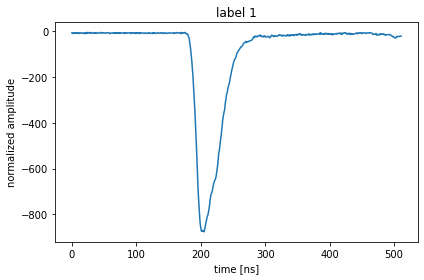

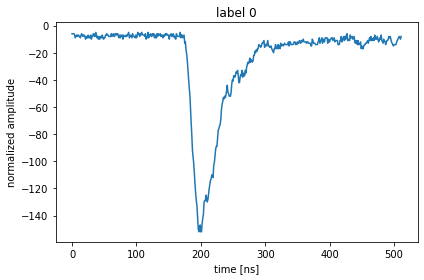

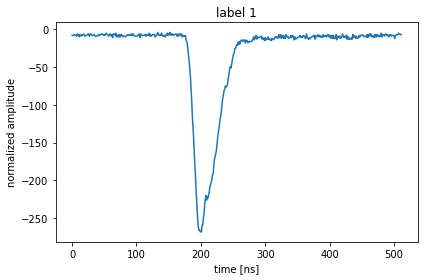

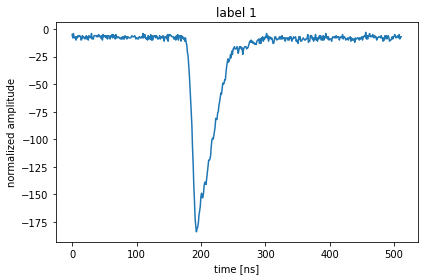

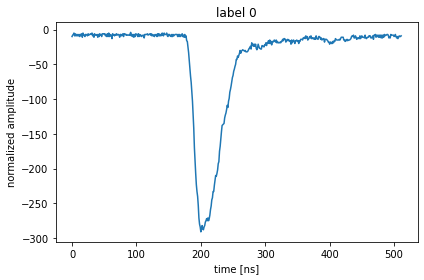

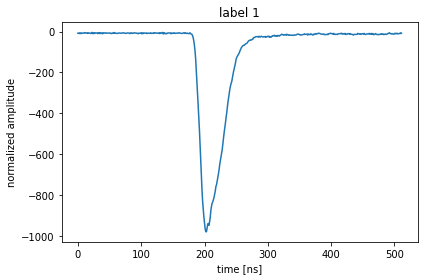

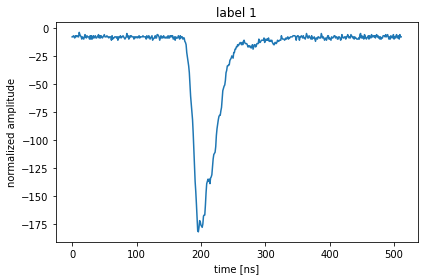

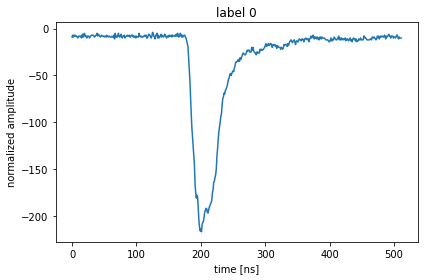

In [99]:
# plot a few events
for i in range(10):
    fig, ax = plt.subplots(1, 1)
    ax.plot(data_train[i,:,0])
    ax.set_title(f"label {labels_train[i]}")
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("normalized amplitude")
    fig.tight_layout()
    plt.show()
    plt.close("all")

In [100]:
import os
path = os.path.join('saved_models')
if not os.path.exists(path):
    os.makedirs(path)

Now we can define the neural network and train it. 

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 512)               0         
                                                                 
 dense_62 (Dense)            (None, 20)                10260     
                                                                 
 dense_63 (Dense)            (None, 2)                 42        
                                                                 
Total params: 10,302
Trainable params: 10,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
530/530 [==============================] - 2s 3ms/step - loss: 2.2345 - accuracy: 0.8978 - val_loss: 1.0344 - val_accuracy: 0.9615
Epoch 2/10
530/530 [==============================] - 1s 2ms/step - loss: 1.0688 - accuracy: 0.9318 - val_loss: 0.7394 - val_accuracy: 0.9510
Epoch 3/10
530/530 [====

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


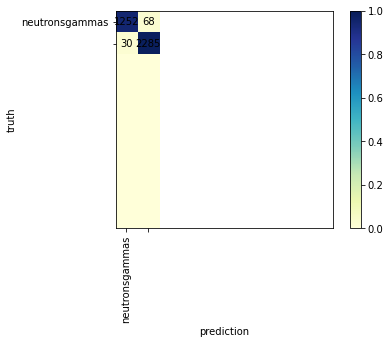

In [102]:
# first the usual imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, Input, Flatten, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle

# confusion matrix function
def plot_confusion(Y_true, Y_predict):
    
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(2), ['neutrons' 'gammas'], rotation="vertical")
    plt.yticks(range(2), ['neutrons' 'gammas'])
    for x in range(2):
        for y in range(2):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")

model = Sequential()

# if you use a fully connected network (dense) you need to flatten the input data first. You can implement this 
# as a network layer: 

model.add(Flatten(input_shape=(samples_per_pulse, 1)))
model.add(Dense(20, activation='relu')) 
model.add(Dense(2, activation = 'softmax'))  

print(model.summary())

model.compile(
    loss='categorical_crossentropy', 
    optimizer= 'adam',
    metrics=['accuracy'])

# train model
results = model.fit(
    data_train, labels_train_onehot,
    validation_data=(data_validation, labels_validation_onehot),
    batch_size=32,
    epochs=10,
    )

# evaluate model
print("\n accuracy for test dataset after training is", model.evaluate(data_test, labels_test_onehot)[1])
labels_predict_onehot = model.predict(data_test, batch_size=128)

# convert back to class labels (0-1)
labels_predict = np.argmax(labels_predict_onehot, axis=1)
labels_test = np.argmax(labels_test_onehot, axis=1)

# confusion matrix
plot_confusion(labels_test, labels_predict)

*1) Start with a small neural network with just one hidden layer. What performance do you obtain? (To evaluate the performance of your network plot a histogram of the network output for the two categories and calculate the confusion matrix).*

With a simple neural network, the performance obtain are already very good with an accuracy over 97%. The confusion matrix is plotted above

In [103]:
model = Sequential()

# larger network 

model.add(Flatten(input_shape=(samples_per_pulse, 1)))
model.add(Dense(20, activation='relu')) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(100, activation='relu')) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(2, activation = 'softmax'))  

print(model.summary())

model.compile(
    loss='categorical_crossentropy', 
    optimizer= 'adam',
    metrics=['accuracy'])

# train model
results = model.fit(
    data_train, labels_train_onehot,
    validation_data=(data_validation, labels_validation_onehot),
    batch_size=32,
    epochs=10,
    )

# evaluate model
print("\n accuracy for test dataset after training is", model.evaluate(data_test, labels_test_onehot)[1])
labels_predict_onehot = model.predict(data_test, batch_size=128)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_34 (Flatten)        (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 20)                10260     
                                                                 
 dense_65 (Dense)            (None, 50)                1050      
                                                                 
 dense_66 (Dense)            (None, 100)               5100      
                                                                 
 dense_67 (Dense)            (None, 50)                5050      
                                                                 
 dense_68 (Dense)            (None, 2)                 102       
                                                                 
Total params: 21,562
Trainable params: 21,562
Non-tra

*2) How much does the performance improves with a larger, more powerful network? How do you explain your observation?* 

With deeper network, the accuracy remain almost as same as with simple artificial neural network, that is around 97%.

I'm not sure how to interprete this, but one idea is that if the network itself doesn't improve performance with a more optimized structure, the limitation might come from another source than the network capacity itself. Some dataset for instance are wrong, noisy or possibly too complex to get a perfect accuracy, due to the dataset itself. Another reason is that the dataset might not be balanced, giving a bias perception to the network.

*3) What can you do to improve the classification accuracy?*

The accuracy could be improved potentially by using another kind og network such as CNN that is know for best performance when it comes to classification.

Also, the network use above was improve adding a few layers but there is other means of improvement that hasn't been improve, such as activation function, batch size and so on, a grid search could finding better results.



*4) How reliable is the accuracy that you estimated from the test data set? Is the true accuracy systematically different from your estimate? If yes, what is your best guess of the true accuracy?* 

As discussed during the lab visit, the all dataset is polluted with noise, giving wrong labelling within the dataset itself. This leads to the network training itself with wrong information and hence learning wrong.
In conclusion this leads to an accuracy that is different from the true accuracy of the network.